# Advanced neural networks

&copy; 李浩东 3190104890@zju.edu.cn

- Modern Convolution Neural Network (CNN)
- Recurrent neural network (RNN)
- Natural language process (NLP)
- You only look once (YOLO)
- Some resources


# Learning Representations

- Up until 2012 the representation was calculated mechanically. In fact, engineering a new set of feature functions, improving results, and writing up the method was a prominent genre of paper. Like some functions in OpenCV.
- Features themselves ought to be learned, to be hierarchically composed with multiple jointly learned layers, each with learnable parameters.

![filters.png](./images/8/filters.png)



![ww](./images/8/alexnet.png)


# From LeNet (left) to AlexNet (right)

![alexnet.svg](./images/8/alexnet.svg)


In [1]:
import torch
from torch import nn
print(torch.__version__)

1.10.0+cu113


In [2]:
def alexnet():
    alexnet = nn.Sequential(
        # Here, we use a larger 11 x 11 window to capture objects. At the same
        # time, we use a stride of 4 to greatly reduce the height and width of the
        # output. Here, the number of output channels is much larger than that in
        # LeNet
        nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        # Make the convolution window smaller, set padding to 2 for consistent
        # height and width across the input and output, and increase the number of
        # output channels
        nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        # Use three successive convolutional layers and a smaller convolution
        # window. Except for the final convolutional layer, the number of output
        # channels is further increased. Pooling layers are not used to reduce the
        # height and width of input after the first two convolutional layers
        nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
        nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
        nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Flatten(),
        # Here, the number of outputs of the fully-connected layer is several
        # times larger than that in LeNet. Use the dropout layer to mitigate
        # overfitting
        nn.Linear(6400, 4096), nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096), nn.ReLU(),
        nn.Dropout(p=0.5),
        # Output layer. Since we are using CIFAR-10, the number of classes is
        # 10, instead of 1000 as in the paper
        nn.Linear(4096, 10))
    return alexnet

In [3]:
X = torch.randn(128, 3, 224, 224)
alex = alexnet()
for layer in alex:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([128, 96, 54, 54])
ReLU output shape:	 torch.Size([128, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([128, 96, 26, 26])
Conv2d output shape:	 torch.Size([128, 256, 26, 26])
ReLU output shape:	 torch.Size([128, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([128, 256, 12, 12])
Conv2d output shape:	 torch.Size([128, 384, 12, 12])
ReLU output shape:	 torch.Size([128, 384, 12, 12])
Conv2d output shape:	 torch.Size([128, 384, 12, 12])
ReLU output shape:	 torch.Size([128, 384, 12, 12])
Conv2d output shape:	 torch.Size([128, 256, 12, 12])
ReLU output shape:	 torch.Size([128, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([128, 256, 5, 5])
Flatten output shape:	 torch.Size([128, 6400])
Linear output shape:	 torch.Size([128, 4096])
ReLU output shape:	 torch.Size([128, 4096])
Dropout output shape:	 torch.Size([128, 4096])
Linear output shape:	 torch.Size([128, 4096])
ReLU output shape:	 torch.Size([128, 4096])
Dropout output shape:	 torch.Size([128, 409

In [4]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.model = alexnet()
    def forward(self, x):
        x = self.model(x)
        return x

In [5]:
print(alexnet())

Sequential(
  (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=6400, out_features=4096, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=4096, out_features=4096, bias=True)
  (18): ReLU()
  (19): Dropout(p=0.5, inplace=False)
  (20): Linear(in_featu

In [2]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(224),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                ])
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)
print(len(train_data))
print(len(test_data))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
50000
10000


In [4]:
num_workers = 0
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 224, 224])
torch.Size([128])


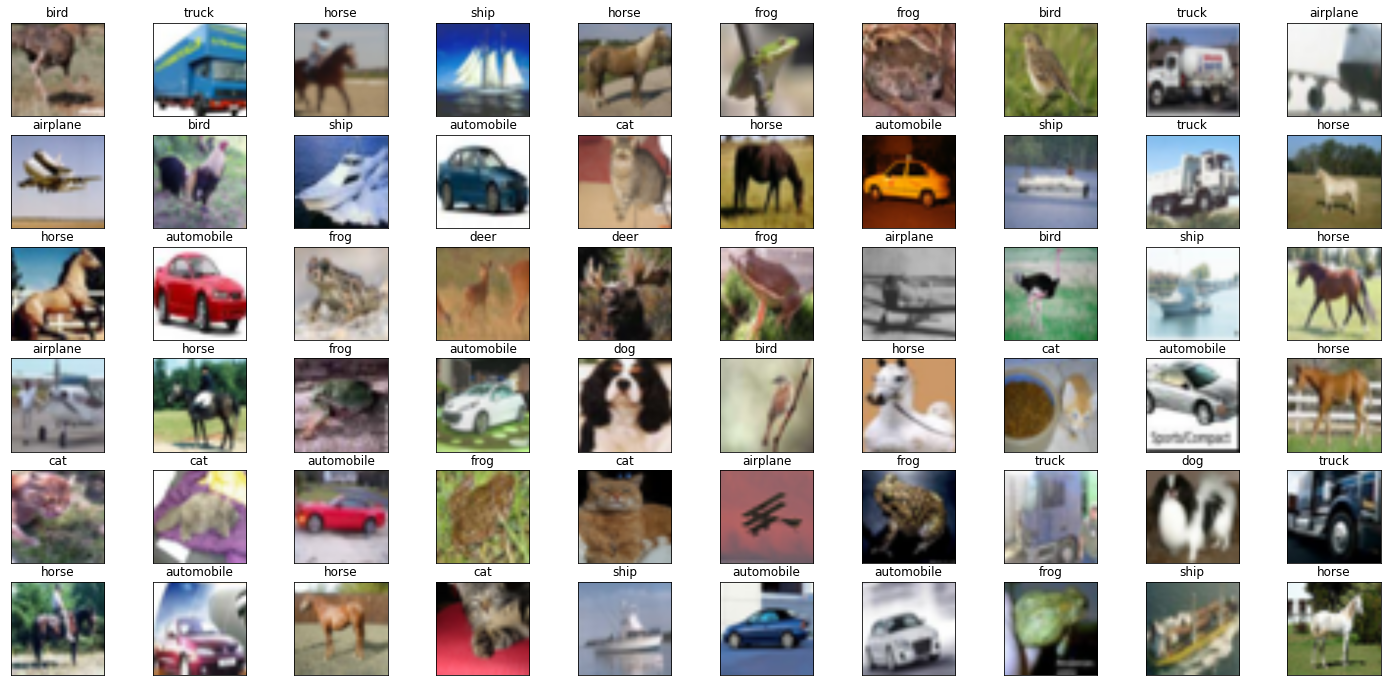

In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
fig = plt.figure(figsize=(25, 12))
for i in np.arange(60):
    ax = fig.add_subplot(6, 10, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

<class 'numpy.ndarray'>
(3, 224, 224)


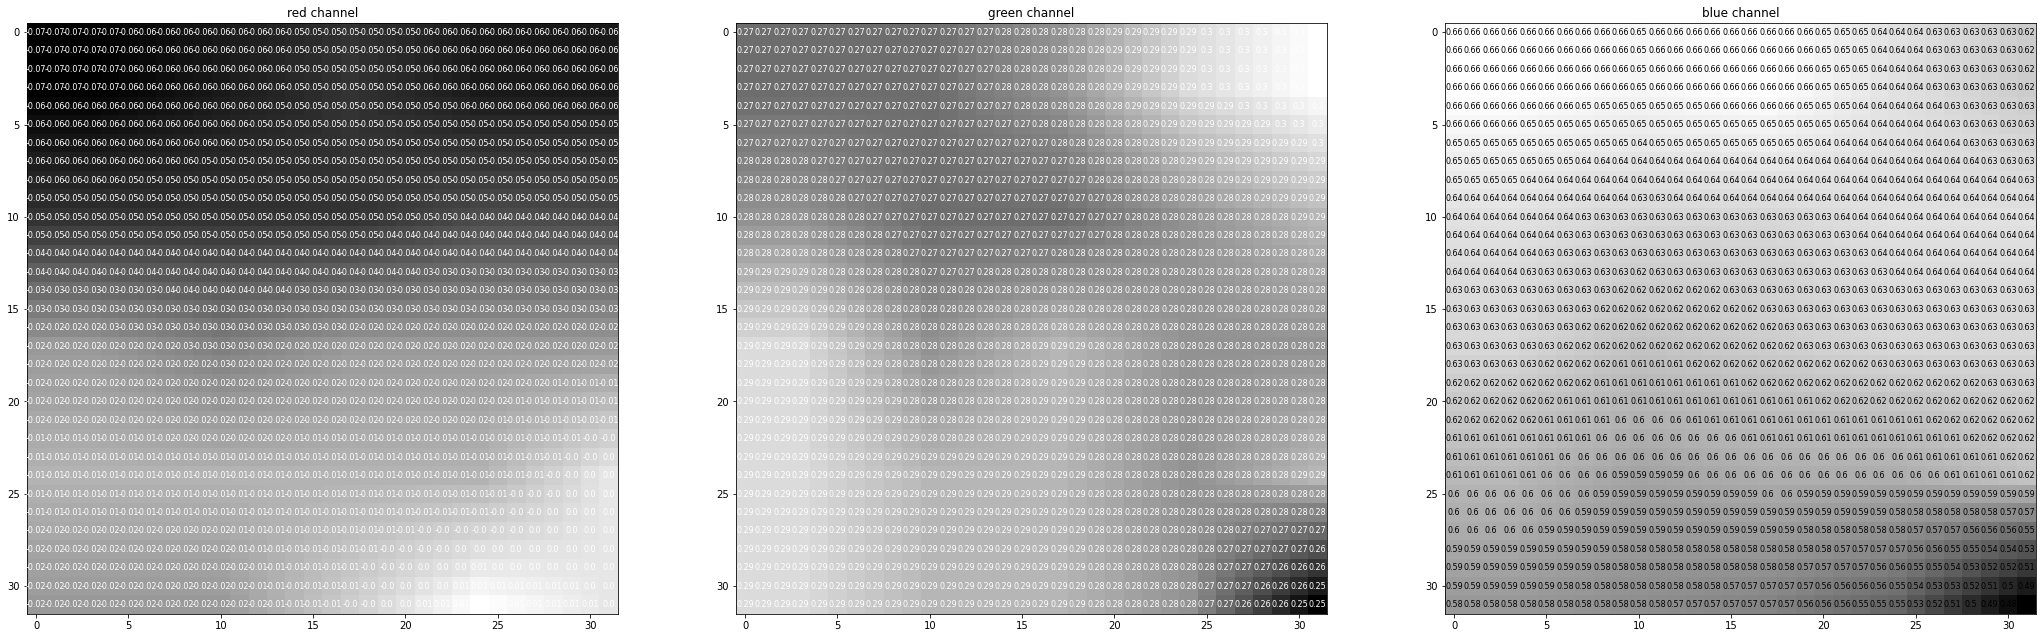

In [6]:
rgb_img = np.squeeze(images[19])
print(type(rgb_img))
print(rgb_img.shape)
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img[:32, :32], cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(32):
        for y in range(32):
            val = round(img[x][y], 2) if img[x][y] != 0 else 0
            ax.annotate(str(val), xy=(y,x),
                horizontalalignment='center',
                verticalalignment='center', size=8,
                color='white' if img[x][y] < thresh else 'black')

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train_model(model, name, epoch_num=500,device='gpu', learning_rate=0.01):
    if device == 'cuda':
        print("Use CUDA for training.")
        model = torch.nn.DataParallel(model) # make parallel
        cudnn.benchmark = True
        
    # specify loss function
    criterion = nn.CrossEntropyLoss()
    # specify optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    train_losslist = []
    valid_losslist = []
    train_acclist = []
    valid_acclist = []

    for epoch in range(1, epoch_num+1):
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0

#         model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            acc = accuracy(output, target)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            train_acc += acc.item()*data.size(0)

#         model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            acc = accuracy(output, target)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            valid_acc += acc.item()*data.size(0)

        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(test_loader.dataset)
        train_acc = train_acc/len(train_loader.dataset)
        valid_acc = valid_acc/len(test_loader.dataset)
        train_losslist.append(train_loss)
        valid_losslist.append(valid_loss)
        train_acclist.append(train_acc)
        valid_acclist.append(valid_acc)
        print("Epoch ->", epoch, "\t train_loss ->", train_loss, "\t\t\t train_acc ->", train_acc, 
              "\n==========\t valid_loss ->", valid_loss, "\t\t\t valid_acc ->", valid_acc)

    torch.save(model.state_dict(), './result/cifar_' + name + '.pt')
    return train_acclist, valid_acclist, train_losslist, valid_losslist

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
os.mkdir("./result/")
print(torch.cuda.get_arch_list(), device)
train_acclist, valid_acclist, train_losslist, valid_losslist = train_model(AlexNet(), "alexnet", 10, device, learning_rate=0.1)

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86'] cuda
Use CUDA for training.
Epoch -> 1 	 train_loss -> 2.157024055786133 			 train_acc -> 0.19450000000476836 
==========	 valid_loss -> 1.9041380699157715 			 valid_acc -> 0.2916
Epoch -> 2 	 train_loss -> 1.7626686682891846 			 train_acc -> 0.35267999998092653 
==========	 valid_loss -> 1.63663171749115 			 valid_acc -> 0.412
Epoch -> 3 	 train_loss -> 1.4755991777801514 			 train_acc -> 0.46270000001907347 
==========	 valid_loss -> 1.3701823890686036 			 valid_acc -> 0.5138
Epoch -> 4 	 train_loss -> 1.2465702711868285 			 train_acc -> 0.5558400000381469 
==========	 valid_loss -> 1.2205792970657348 			 valid_acc -> 0.5585
Epoch -> 5 	 train_loss -> 1.0468435781478882 			 train_acc -> 0.63272 
==========	 valid_loss -> 1.007874684715271 			 valid_acc -> 0.65
Epoch -> 6 	 train_loss -> 0.8842423446273804 			 train_acc -> 0.6907199999618531 
==========	 valid_loss -> 1.1401259311676026 			 valid_acc -> 0.6046
Epoch -> 7 

In [8]:
def plot_accuracies(train_acclist, valid_acclist):
    plt.plot(train_acclist, '-rx')
    plt.plot(valid_acclist, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')

def plot_losses(train_losslist, valid_losslist):
    plt.plot(train_losslist, '-bx')
    plt.plot(valid_losslist, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

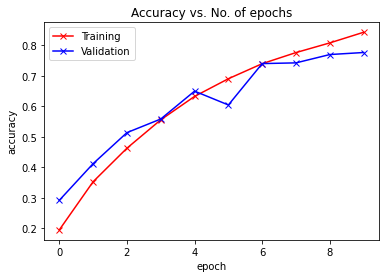

In [14]:
plot_accuracies(train_acclist, valid_acclist)

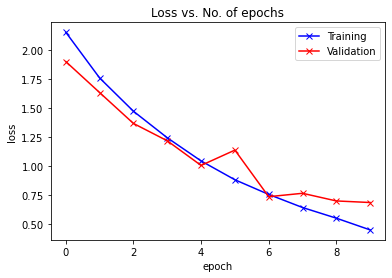

In [15]:
plot_losses(train_losslist, valid_losslist)

# Networks Using Blocks (VGG)

- While AlexNet offered empirical evidence that deep CNNs can achieve good results, it did not provide a general template to guide subsequent researchers in designing new networks.
- The basic building block of classic CNNs is a sequence of the following:
    - (i) a convolutional layer with padding to maintain the resolution, 
    - (ii) a nonlinearity such as a ReLU, 
    - (iii) a pooling layer such as a maximum pooling layer. 
- One VGG block consists of a sequence of convolutional layers, followed by a maximum pooling layer for spatial downsampling.



![vgg](./images/8/vgg.png)


# AlexNet V.S. VGG

![1](./images/8/vgg.svg)


In [9]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [10]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 3
    # The convolutional part
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # The fully-connected part
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
vggnet = vgg(conv_arch)

In [11]:
print(vggnet)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4):

In [19]:
X = torch.randn(size=(128, 3, 224, 224))
for blk in vggnet:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([128, 64, 112, 112])
Sequential output shape:	 torch.Size([128, 128, 56, 56])
Sequential output shape:	 torch.Size([128, 256, 28, 28])
Sequential output shape:	 torch.Size([128, 512, 14, 14])
Sequential output shape:	 torch.Size([128, 512, 7, 7])
Flatten output shape:	 torch.Size([128, 25088])
Linear output shape:	 torch.Size([128, 4096])
ReLU output shape:	 torch.Size([128, 4096])
Dropout output shape:	 torch.Size([128, 4096])
Linear output shape:	 torch.Size([128, 4096])
ReLU output shape:	 torch.Size([128, 4096])
Dropout output shape:	 torch.Size([128, 4096])
Linear output shape:	 torch.Size([128, 10])


In [12]:
class VGGNet(nn.Module):
    def __init__(self, conv_arch):
        super(VGGNet, self).__init__()
        self.model = vgg(conv_arch)
    def forward(self, x):
        x = self.model(x)
        return x

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)
train_acclist, valid_acclist, train_losslist, valid_losslist = train_model(VGGNet(conv_arch), "vggnet", 10, device, learning_rate=0.1)

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86'] cuda
Use CUDA for training.
Epoch -> 1 	 train_loss -> 2.302887268371582 			 train_acc -> 0.09755999999523163 
==========	 valid_loss -> 2.3028270275115967 			 valid_acc -> 0.0995
Epoch -> 2 	 train_loss -> 2.3027088862609864 			 train_acc -> 0.09872 
==========	 valid_loss -> 2.302776969909668 			 valid_acc -> 0.0998
Epoch -> 3 	 train_loss -> 2.3028810122680663 			 train_acc -> 0.09892 
==========	 valid_loss -> 2.3026444580078125 			 valid_acc -> 0.1
Epoch -> 4 	 train_loss -> 2.3023598937988283 			 train_acc -> 0.10355999999523163 
==========	 valid_loss -> 2.2998690208435058 			 valid_acc -> 0.1083
Epoch -> 5 	 train_loss -> 2.219375960121155 			 train_acc -> 0.1754000000190735 
==========	 valid_loss -> 2.0665507686614992 			 valid_acc -> 0.2673
Epoch -> 6 	 train_loss -> 1.9155887814712524 			 train_acc -> 0.29143999999046327 
==========	 valid_loss -> 1.6988265672683716 			 valid_acc -> 0.3706
Epoch -> 7 	 train_lo

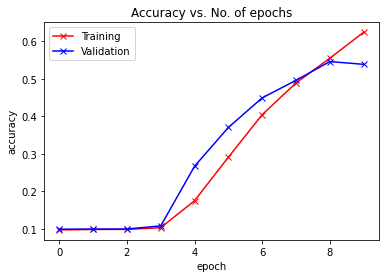

In [31]:
plot_accuracies(train_acclist, valid_acclist)

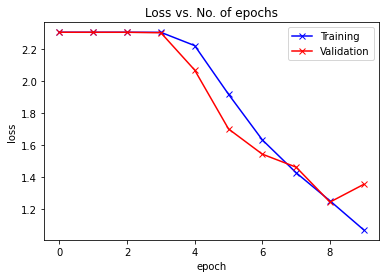

In [32]:
plot_losses(train_losslist, valid_losslist)

In [13]:
ratio = 4
conv_arch_small = [(pair[0], pair[1] // ratio) for pair in conv_arch]
vggnet_small = vgg(conv_arch_small)

In [14]:
print(vggnet_small)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Seque

In [15]:
X = torch.randn(size=(128, 3, 224, 224))
for blk in vggnet_small:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([128, 16, 112, 112])
Sequential output shape:	 torch.Size([128, 32, 56, 56])
Sequential output shape:	 torch.Size([128, 64, 28, 28])
Sequential output shape:	 torch.Size([128, 128, 14, 14])
Sequential output shape:	 torch.Size([128, 128, 7, 7])
Flatten output shape:	 torch.Size([128, 6272])
Linear output shape:	 torch.Size([128, 4096])
ReLU output shape:	 torch.Size([128, 4096])
Dropout output shape:	 torch.Size([128, 4096])
Linear output shape:	 torch.Size([128, 4096])
ReLU output shape:	 torch.Size([128, 4096])
Dropout output shape:	 torch.Size([128, 4096])
Linear output shape:	 torch.Size([128, 10])


In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)
train_acclist, valid_acclist, train_losslist, valid_losslist = train_model(VGGNet(conv_arch_small), "vggnet_small", 10, device, learning_rate=0.1)

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86'] cuda
Use CUDA for training.
Epoch -> 1 	 train_loss -> 2.302932787628174 			 train_acc -> 0.0960600000011921 
==========	 valid_loss -> 2.3026234802246095 			 valid_acc -> 0.0993
Epoch -> 2 	 train_loss -> 2.30281301864624 			 train_acc -> 0.09902000000476838 
==========	 valid_loss -> 2.3028244819641115 			 valid_acc -> 0.0973
Epoch -> 3 	 train_loss -> 2.302931197052002 			 train_acc -> 0.09988000000238419 
==========	 valid_loss -> 2.3027171588897706 			 valid_acc -> 0.1
Epoch -> 4 	 train_loss -> 2.3028813500976564 			 train_acc -> 0.09903999999523162 
==========	 valid_loss -> 2.302652516937256 			 valid_acc -> 0.1
Epoch -> 5 	 train_loss -> 2.302744821548462 			 train_acc -> 0.10022000000476837 
==========	 valid_loss -> 2.302427421569824 			 valid_acc -> 0.1028
Epoch -> 6 	 train_loss -> 2.256916834716797 			 train_acc -> 0.14739999999046324 
==========	 valid_loss -> 2.056313734817505 			 valid_acc -> 0.2518
Epoch 

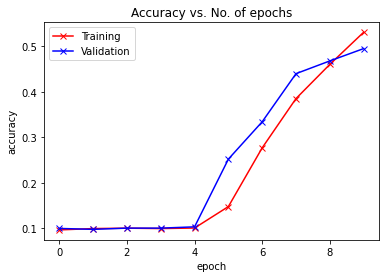

In [19]:
plot_accuracies(train_acclist, valid_acclist)

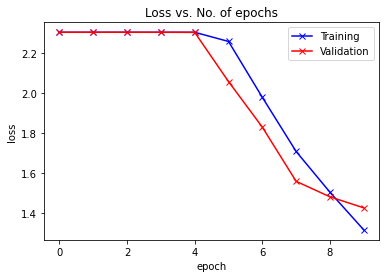

In [20]:
plot_losses(train_losslist, valid_losslist)

# Network in Network (NiN)

- LeNet, AlexNet, and VGG all share a common design pattern: extract features exploiting spatial structure via a sequence of convolution and pooling layers and then post-process the representations via fully-connected layers. 
- The improvements upon LeNet by AlexNet and VGG mainly lie in how these later networks widen and deepen these two modules. 
- Alternatively, one could imagine using fully-connected layers earlier in the process. However, a careless use of dense layers might give up the spatial structure of the representation entirely, network in network (NiN) blocks offer an alternative.
- Recall that the inputs and outputs of convolutional layers consist of four-dimensional tensors with axes corresponding to the example, channel, height, and width. Also recall that the inputs and outputs of fully-connected layers are typically two-dimensional tensors corresponding to the example and feature. 
- The idea behind NiN is to apply a fully-connected layer at each pixel location (for each height and width). If we tie the weights across each spatial location, we could think of this as a $1\times 1$ convolutional layer or as a fully-connected layer acting independently on each pixel location.

![nin](./images/8/nin.png)

# VGG V.S. NIN

![1](./images/8/nin.svg)

In [21]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

In [22]:
def nin_net():
    net = nn.Sequential(
        nin_block(3, 96, kernel_size=11, strides=4, padding=0),
        nn.MaxPool2d(3, stride=2),
        nin_block(96, 256, kernel_size=5, strides=1, padding=2),
        nn.MaxPool2d(3, stride=2),
        nin_block(256, 384, kernel_size=3, strides=1, padding=1),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout(0.5),
        # There are 10 label classes
        nin_block(384, 10, kernel_size=3, strides=1, padding=1),
        nn.AdaptiveAvgPool2d((1, 1)),
        # Transform the four-dimensional output into two-dimensional output with a
        # shape of (batch size, 10)
        nn.Flatten())
    return net

In [23]:
ninnet = nin_net()
print(ninnet)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (5): MaxPool2d(kernel_size=3, stri

In [24]:
X = torch.rand(size=(128, 3, 224, 224))
for layer in ninnet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([128, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([128, 96, 26, 26])
Sequential output shape:	 torch.Size([128, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([128, 256, 12, 12])
Sequential output shape:	 torch.Size([128, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([128, 384, 5, 5])
Dropout output shape:	 torch.Size([128, 384, 5, 5])
Sequential output shape:	 torch.Size([128, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([128, 10, 1, 1])
Flatten output shape:	 torch.Size([128, 10])


In [25]:
class NINNet(nn.Module):
    def __init__(self):
        super(NINNet, self).__init__()
        self.model = nin_net()
    def forward(self, x):
        x = self.model(x)
        return x

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)
train_acclist, valid_acclist, train_losslist, valid_losslist = train_model(NINNet(), "ninnet", 10, device, learning_rate=0.1)

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86'] cuda
Use CUDA for training.
Epoch -> 1 	 train_loss -> 2.303594979476929 			 train_acc -> 0.09967999999523162 
==========	 valid_loss -> 2.302683427429199 			 valid_acc -> 0.1
Epoch -> 2 	 train_loss -> 2.3026312473297117 			 train_acc -> 0.10125999999761581 
==========	 valid_loss -> 2.3025852306365966 			 valid_acc -> 0.0979
Epoch -> 3 	 train_loss -> 2.302585174179077 			 train_acc -> 0.09970000000953674 
==========	 valid_loss -> 2.3025851612091066 			 valid_acc -> 0.1013
Epoch -> 4 	 train_loss -> 2.3025851710510254 			 train_acc -> 0.10059999999523163 
==========	 valid_loss -> 2.3025852672576903 			 valid_acc -> 0.0979
Epoch -> 5 	 train_loss -> 2.302585093536377 			 train_acc -> 0.09862000000238419 
==========	 valid_loss -> 2.302585031890869 			 valid_acc -> 0.1039
Epoch -> 6 	 train_loss -> 2.3025851303863525 			 train_acc -> 0.09997999999523163 
==========	 valid_loss -> 2.302585028839111 			 valid_acc -> 0.1017

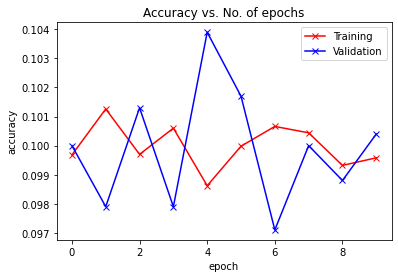

In [27]:
plot_accuracies(train_acclist, valid_acclist)

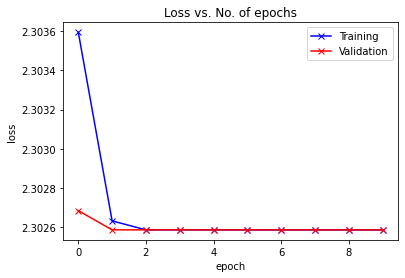

In [28]:
plot_losses(train_losslist, valid_losslist)

# Networks with Parallel Concatenations (GoogLeNet)

- In 2014, GoogLeNet won the ImageNet Challenge, proposing a structure that combined the strengths of NiN and paradigms of repeated blocks.
- One focus of the paper was to address the question of which sized convolution kernels are best.
- After all, previous popular networks employed choices as small as $1\times 1$ and as large as $11\times 11$. 
- One insight in this paper was that sometimes it can be advantageous to employ a combination of variously-sized kernels.


# Inception Blocks

![inception.svg](./images/8/inception.svg)


# GoogLeNet Model

![inception-full](./images/8/inception-full.svg)
